In [26]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel

class TVRegression(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, x_t):
        ones = np.ones(len(x_t))
        exog = np.c_[x_t,ones]  # shaped nobs x 2

        super(TVRegression, self).__init__(
            endog=y_t, exog=exog, k_states=2, initialization="diffuse"
        )

        # Since the design matrix is time-varying, it must be
        # shaped k_endog x k_states x nobs
        # Notice that exog.T is shaped k_states x nobs, so we
        # just need to add a new first axis with shape 1
        self.ssm["design"] = exog.T[np.newaxis, :, :]  # shaped 1 x 2 x nobs
        self.ssm["selection"] = np.eye(self.k_states)
        self.ssm["transition"] = np.eye(self.k_states)

        # Which parameters need to be positive?
        self.positive_parameters = slice(0, 3)

    @property
    def param_names(self):
        return ["var.e", "var.beta.coeff", "var.alpha.coeff"]

    @property
    def start_params(self):
        """
        Defines the starting values for the parameters
        The linear regression gives us reasonable starting values for the constant
        d and the variance of the epsilon error
        """
        res = sm.OLS(self.endog, self.exog).fit()
        params = np.r_[res.scale, 0.001, 0.001]
        return params

    def transform_params(self, unconstrained):
        """
        We constraint the last three parameters
        ('var.e', 'var.x.coeff', 'var.w.coeff') to be positive,
        because they are variances
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = (
            constrained[self.positive_parameters] ** 2
        )
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = (
            unconstrained[self.positive_parameters] ** 0.5
        )
        return unconstrained

    def update(self, params, **kwargs):
        params = super(TVRegression, self).update(params, **kwargs)

        self["obs_cov", 0, 0] = params[0]
        self["state_cov"] = np.diag(params[1:3])

# Example usage:
# Load data
corners = ['SMALL LoBM', 'SMALL HiBM', 'BIG LoBM', 'BIG HiBM']
url_pfo_25 = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/25_Portfolios_5x5_CSV.zip"


def get_data_BM(url, skiprows, nrows):
    return pd.read_csv(
        url,
        compression="zip",
        skiprows=skiprows,
        nrows=nrows,
        index_col=0,
        parse_dates=True,
        date_format="%Y%m"
    )["196307":"202402"]

def TVRegress(Y,X,RF):
    mod = TVRegression(Y.to_numpy() - RF.to_numpy(), X.to_numpy())
    res = mod.fit()
    return res

def plotter(model,label,axes,time_period):
    ss = pd.DataFrame(model.smoothed_state.T, columns=["x", "w"])
    axes[0].plot(time_period, ss["x"], label=label)
    axes[1].plot(time_period, ss["w"], label=label)

pfo_25 = get_data_BM(url_pfo_25, skiprows=15, nrows=1174) ### endogenous
ff5 = get_data(url_ff5, skiprows=3, nrows=728)
Mkt_excess = ff5[["Mkt-RF"]] ### Exogenous
RF = ff5["RF"]
filtered = [TVRegress(pfo_25[pfolio],Mkt_excess,RF) for pfolio in corners]

In [25]:
filtered[3].params

array([1.12414232e+01, 4.03056142e-03, 1.79731158e-04])

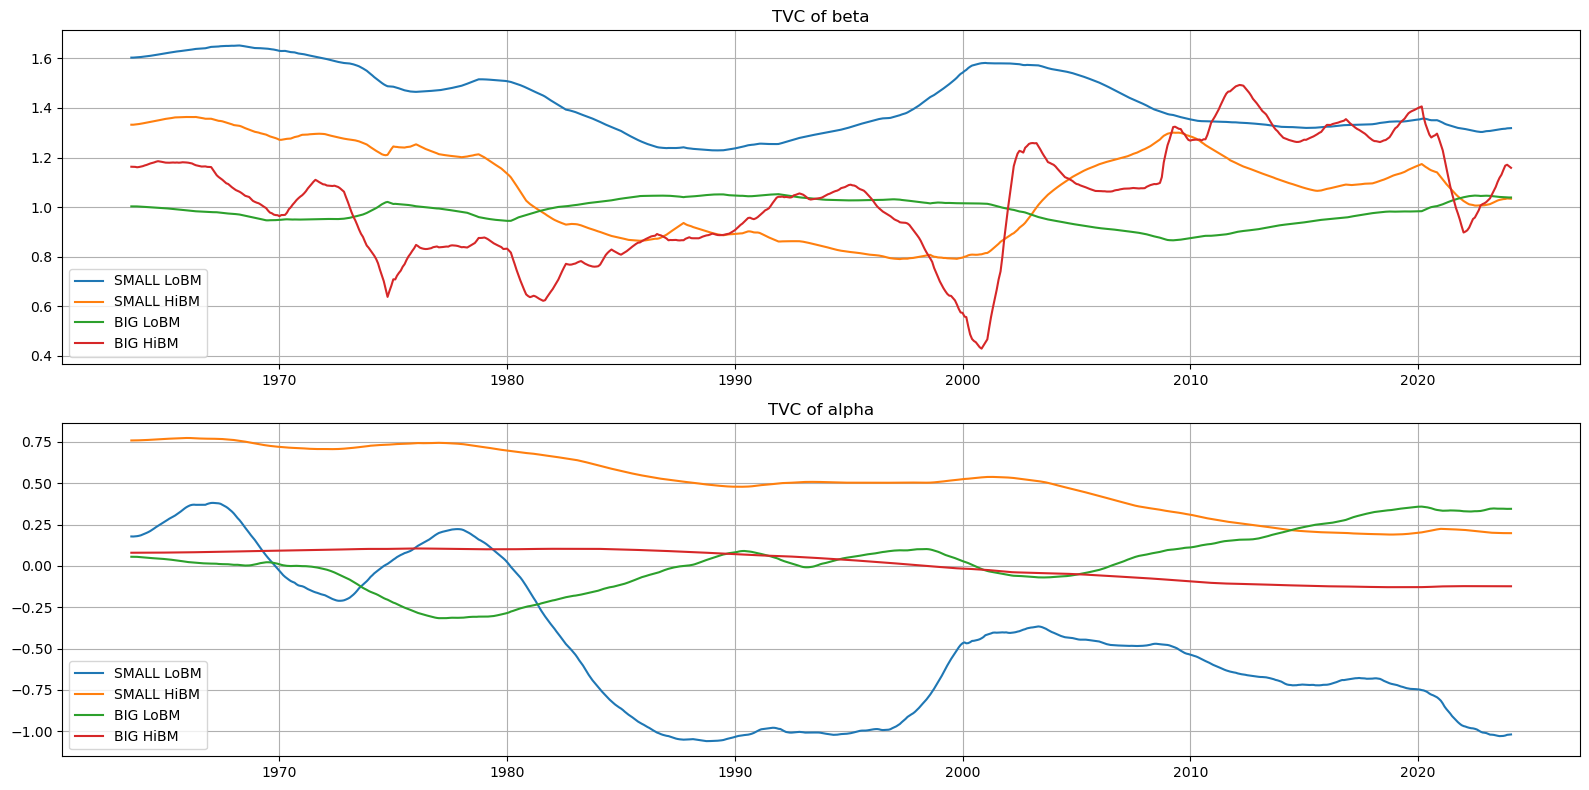

In [15]:
fig, axes = plt.subplots(2, figsize=(16, 8))
for i in range(len(filtered)):
    plotter(filtered[i],corners[i],axes,ff5.index)
    
axes[0].set(title="TVC of beta")
axes[0].legend()
axes[0].grid()
axes[1].set(title="TVC of alpha")
axes[1].legend()
axes[1].grid()

fig.tight_layout();

### Observations for TVR on corner portfolios

- Betas of corner portfolios seem to maintain a certain level across all the different corner portfolios except the Big HiBM portfolio. Big HiBM seems to have had a downtrend of betas in the early $2000s$ and another dip in early $2020s$
- The pricing errors on the other hand seem to be close to $0$ for Big LoBM and Big HiBM portfolios for a majority of time with a slight uptrend in that of Big LoBM from mid $2000s$. Possible that market can no longer fully explain the returns of such portfolios from around the crisis period
- Both Small LoBM and Small HiBM portfolios have significant pricing errors with HiBMs having higher value than LoBMs

In [17]:
import yfinance as yf
msft_data = yf.download(tickers="MSFT", start="1963-06-01", end="2024-03-01", interval="1mo")
ibm_data  = yf.download(tickers="IBM", start="1963-06-01", end="2024-03-01", interval="1mo")
msft_rets = 100*msft_data.pct_change()[1:]
ibm_rets  = 100*ibm_data.pct_change()[1:]
ibm_filtered = TVRegress(ibm_rets["Adj Close"],Mkt_excess,RF)
msft_filtered = TVRegress(msft_rets["Adj Close"],Mkt_excess[274:],RF[274:]) ## adjusting to fit data frame for msft

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


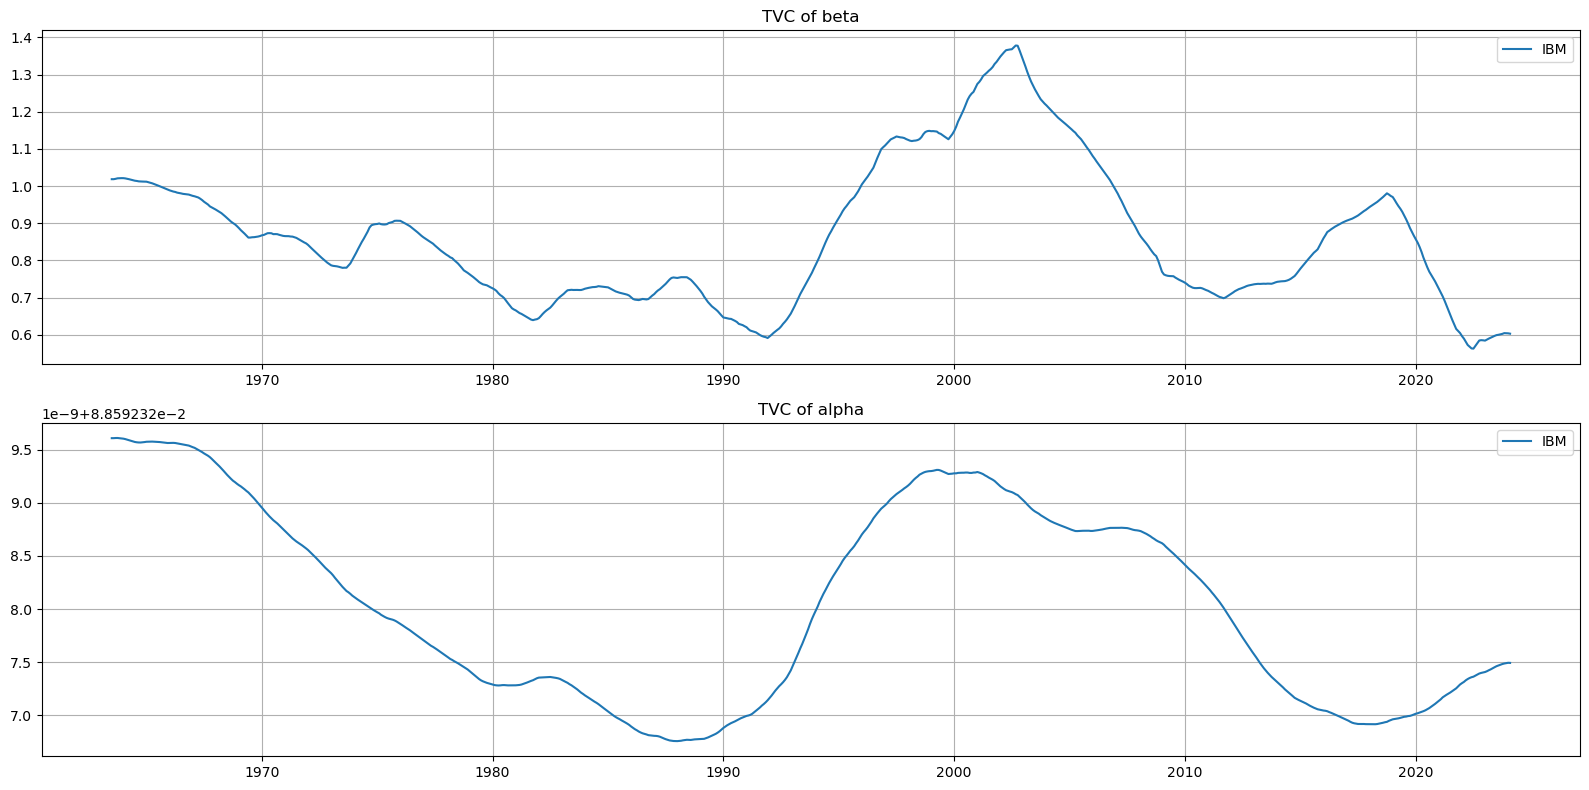

In [18]:
fig, axes = plt.subplots(2, figsize=(16, 8))
plotter(ibm_filtered,"IBM",axes,ff5.index)
    
axes[0].set(title="TVC of beta")
axes[0].legend()
axes[0].grid()
axes[1].set(title="TVC of alpha")
axes[1].legend()
axes[1].grid()

fig.tight_layout();

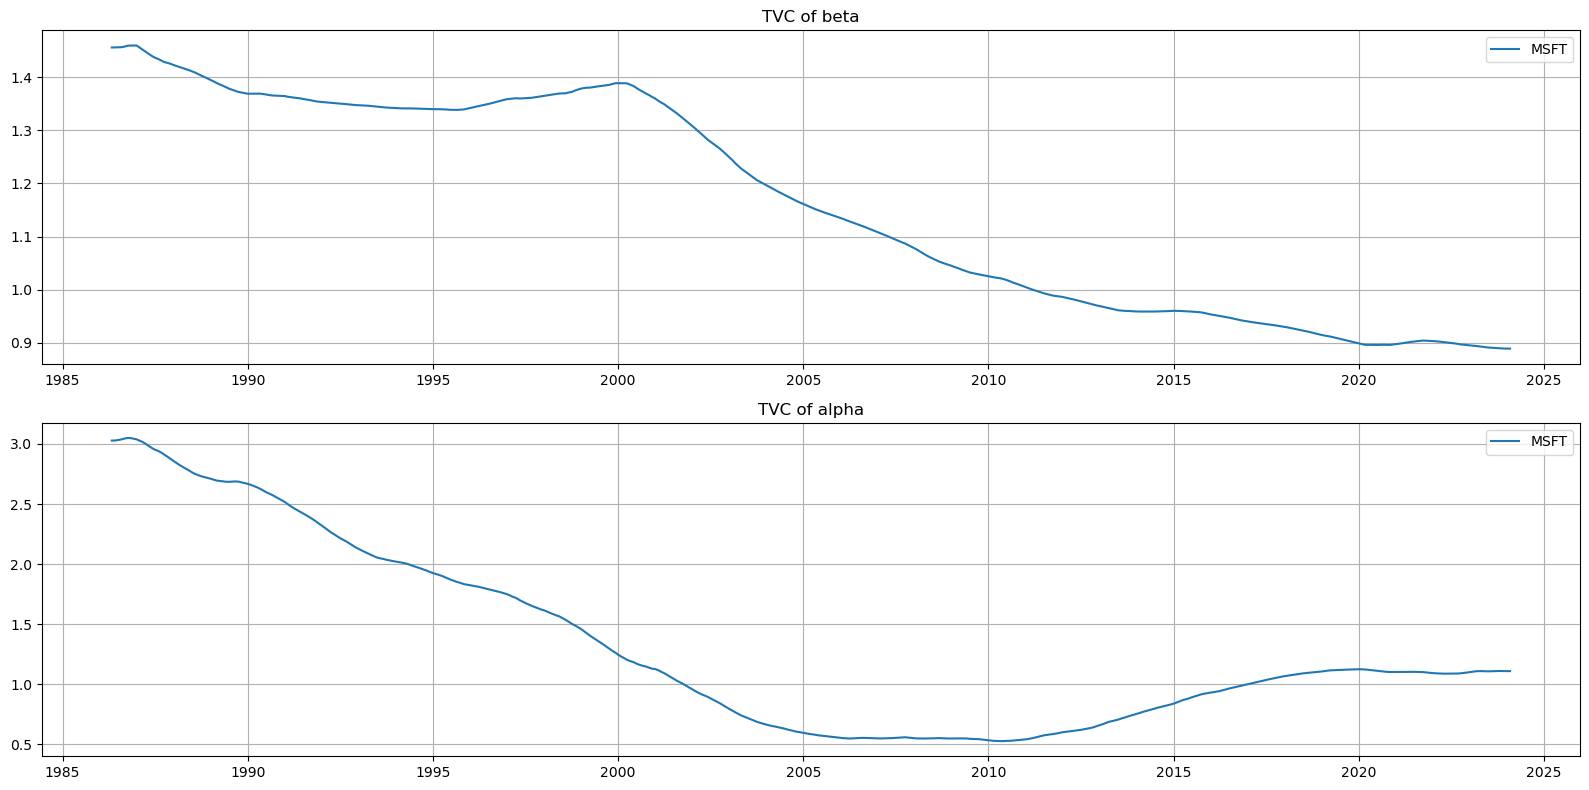

In [20]:
fig, axes = plt.subplots(2, figsize=(16, 8))
plotter(msft_filtered,"MSFT",axes,ff5.index[274:])
    
axes[0].set(title="TVC of beta")
axes[0].legend()
axes[0].grid()
axes[1].set(title="TVC of alpha")
axes[1].legend()
axes[1].grid()

fig.tight_layout();

### MSFT vs IBM vs Corner Pfolios

- IBM has very small pricing errors over the time whereas MSFT had higher pricing errors in the beginning which reduced over time. This behavior is similar to how a Big HiBM more or less has insignificant $\alpha's$ whereas MSFT which started of as a small company which grew over time to switch into Big HiBM regime 
- IBM betas also have a similar downtrend in early $2000's$ as the Big HiBM portfolios and a similar dip in early $2020's$
- MSFT betas on the other hand have similar characteristics of the Small HiBM portfolio in the start and later behave similar to Big HiBM portfolios
- Regime shifts can be attributed to the shift in business model/impact of the business on market which would've attracted more investors etc